In [1]:
from hdt_util import ARLIC_feeder
from hdt_util.delay import Delay
from hdt_util.conv1d import * 
from hdt_util.weekday import Weekday, dow_adjust_cases

from forecasters import ARLIC

import numpy as np
import pandas as pd
import scipy
import datetime
import os
import math
from collections import defaultdict
import tensorflow as tf

import matplotlib.pyplot as plt

## Obtain delay distribution

In [2]:
## Data path globals
# You will have to change the path for the Fl_line_list.csv
fl_line_data = "./FL_line_list.csv"

In [3]:
# https://www.arcgis.com/home/item.html?id=37abda537d17458bae6677b8ab75fcb9
florida_df = pd.read_csv(fl_line_data, parse_dates=["Case_", "EventDate", "ChartDate"])
florida_delays = (florida_df.ChartDate - florida_df.EventDate).dt.days
florida_delays = florida_delays[florida_delays.gt(0) & florida_delays.lt(60)]
delay_dist = Delay.get_delay_distribution(florida_delays)

## Load data and filter for Yolo County

Train on whatever we have and predict the val

In [4]:
loader = ARLIC_feeder('./request_cache')

#this will take a long time
data = loader.get_data(case_source='indicator-combination',
                       case_signal='confirmed',
                       li_source='fb-survey', 
                       li_signal='smoothed_cli', 
                       start_date=datetime.date(2020, 3, 1),
                       end_date=datetime.date(2020, 12, 15), 
                       level='county',
                       geo_values=['06113'])

In [5]:
data.head()

,geo_value,date,case_value,li_value,time,dayofweek
0,06113,2020-04-08,5.571429,1.484552,1,6
1,06113,2020-04-09,5.428571,1.100927,2,0
2,06113,2020-04-10,5.428571,0.997785,3,1
3,06113,2020-04-11,7.285714,0.991403,4,2
4,06113,2020-04-12,8.000000,0.991403,5,3


In [6]:
data.tail()

,geo_value,date,case_value,li_value,time,dayofweek
215,06113,2020-12-08,88.428571,1.338939,216,4
216,06113,2020-12-09,88.428571,0.953318,217,5
217,06113,2020-12-10,100.857143,0.941798,218,6
218,06113,2020-12-11,116.000000,0.863558,219,0
219,06113,2020-12-12,105.571429,0.857738,220,1


## Fitting Model

### Data preprocessing

In [7]:
#220 entries, train with the first 208 (by Nov 30th), predict whatever is in Dec
data = data.sort_values(by='time')
train = data[data['time'] <= 208]
test = data[data['time'] > 208]

In [8]:
cases = train['case_value'].values
cases = tf.reshape(cases, shape=(1,-1,1))

li = train['li_value'].values
cases_mean = tf.reduce_mean(cases)
cases_std = tf.math.reduce_std(cases)

#normalize li and deconvolve
li_mean = tf.reduce_mean(li)
li_std = tf.math.reduce_std(li)
li = pd.DataFrame({'value':li, 'time_value':train['date'].values})
li.value = tf.clip_by_value((cases_std*(li.value-li_mean)/li_std) + cases_mean, clip_value_min=0,clip_value_max=float('inf'))       

li = Delay.deconv(li, delay_dist)
li = tf.reshape(li, shape=(1,-1,1))

### Config Model

In [9]:
model = ARLIC(p=7, delay_dist=delay_dist)
optimizer = tf.keras.optimizers.Adam(lr=1)
loss = tf.keras.losses.MSE

model_path = "ARLIC_MODEL_PATH"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    verbose=0,
    monitor="mean_squared_error",
    save_best_only=True,
    save_weights_only=True
)

callbacks = [
    checkpoint_callback,
]

model.compile(
    optimizer=optimizer,
    loss=loss, 
    metrics=[loss],
)

### Train model

In [10]:
args = {
    "x":li,
    "y":cases,
    "epochs":10000,
    "verbose":0,
    "callbacks":callbacks
} 
model.fit(args)
model.load_weights(model_path).expect_partial()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Predict and Visualization

In [11]:
li = tf.pad(li, paddings=[[0,0],[model.p-1,0],[0,0]])
It = model(li)
It = tf.clip_by_value(It, clip_value_min=0, clip_value_max=float('inf'))
It = tf.pad(It, paddings=[[0,0],[model.delay_dist.shape[0]-1,0],[0,0]]) 

n = 12 # how many days to predict
pred = model.forecast(li, n)
pred = tf.reshape(pred, shape=(1,-1,1))
It = tf.concat([It, pred], axis=1)
It = tf.clip_by_value(It, clip_value_min=0, clip_value_max=float('inf'))

prediction = Delay.conv(It, delay_dist)

prediction = tf.reshape(prediction, shape=-1)[:-1].numpy() 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



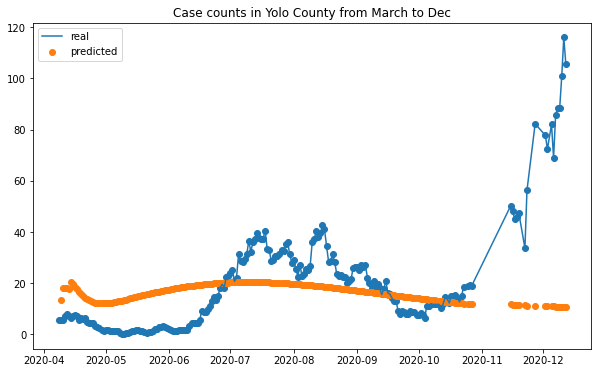

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['case_value'].values, label='real')
plt.scatter(data['date'], data['case_value'].values)
plt.scatter(data['date'][1:], prediction, label='predicted')
plt.title('Case counts in Yolo County from March to Dec')
#plt.vlines(x=208.5, ymin=0, ymax=100, colors='black')
plt.legend()
plt.show()

## Similar procedure for EI Paso

In [13]:
loader = ARLIC_feeder('./request_cache')

data = loader.get_data(case_source='indicator-combination',
                       case_signal='confirmed',
                       li_source='fb-survey', 
                       li_signal='smoothed_cli', 
                       start_date=datetime.date(2020, 3, 1),
                       end_date=datetime.date(2020, 12, 15), 
                       level='county',
                       geo_values=['48141'])

In [14]:
data.head() # notice that the first entries starts earlier

,geo_value,date,case_value,li_value,time,dayofweek
0,48141,2020-04-06,10.714286,0.641053,1,6
1,48141,2020-04-07,11.285714,0.905683,2,0
2,48141,2020-04-08,14.714286,0.733434,3,1
3,48141,2020-04-09,17.714286,0.635944,4,2
4,48141,2020-04-10,21.000000,0.761389,5,3


In [15]:
data.tail()

,geo_value,date,case_value,li_value,time,dayofweek
246,48141,2020-12-08,570.857143,1.538417,247,0
247,48141,2020-12-09,478.714286,1.580472,248,1
248,48141,2020-12-10,425.285714,1.834787,249,2
249,48141,2020-12-11,395.428571,1.877474,250,3
250,48141,2020-12-12,434.857143,1.841642,251,4


In [16]:
data = data.sort_values(by='time')
train = data[data['time'] <= 239]
test = data[data['time'] > 239]

cases = train['case_value'].values
cases = tf.reshape(cases, shape=(1,-1,1))

li = train['li_value'].values
cases_mean = tf.reduce_mean(cases)
cases_std = tf.math.reduce_std(cases)

#normalize li and deconvolve
li_mean = tf.reduce_mean(li)
li_std = tf.math.reduce_std(li)
li = pd.DataFrame({'value':li, 'time_value':train['date'].values})
li.value = tf.clip_by_value((cases_std*(li.value-li_mean)/li_std) + cases_mean, clip_value_min=0,clip_value_max=float('inf'))       

li = Delay.deconv(li, delay_dist)
li = tf.reshape(li, shape=(1,-1,1))

model = ARLIC(p=7, delay_dist=delay_dist)
optimizer = tf.keras.optimizers.Adam(lr=1)
loss = tf.keras.losses.MSE

model_path = "ARLIC_MODEL_PATH"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    verbose=0,
    monitor="mean_squared_error",
    save_best_only=True,
    save_weights_only=True
)

callbacks = [
    checkpoint_callback,
]

model.compile(
    optimizer=optimizer,
    loss=loss, 
    metrics=[loss],
)

args = {
    "x":li,
    "y":cases,
    "epochs":10000,
    "verbose":0,
    "callbacks":callbacks
} 
model.fit(args)
model.load_weights(model_path).expect_partial()

li = tf.pad(li, paddings=[[0,0],[model.p-1,0],[0,0]])
It = model(li)
It = tf.clip_by_value(It, clip_value_min=0, clip_value_max=float('inf'))
It = tf.pad(It, paddings=[[0,0],[model.delay_dist.shape[0]-1,0],[0,0]]) 

n = 12 # how many days to predict
pred = model.forecast(li, n)
pred = tf.reshape(pred, shape=(1,-1,1))
It = tf.concat([It, pred], axis=1)
It = tf.clip_by_value(It, clip_value_min=0, clip_value_max=float('inf'))

prediction = Delay.conv(It, delay_dist)

prediction = tf.reshape(prediction, shape=-1)[:-1].numpy() 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

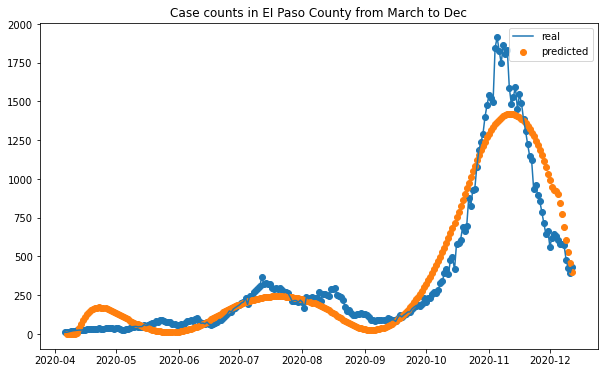

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data['date'], data['case_value'].values, label='real')
plt.scatter(data['date'], data['case_value'].values)
plt.scatter(data['date'][1:], prediction, label='predicted')
plt.title('Case counts in EI Paso County from March to Dec')
#plt.vlines(x=239.5, ymin=0, ymax=2000, colors='black')
plt.legend()
plt.show()